<a href="https://colab.research.google.com/github/sleclair0/harry_potter_nlp/blob/master/LDA_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)



     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
from google.colab import drive
drive.mount('/gdrive')

#from google.colab import drive
#drive.mount('/content/drive')

with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/foo.txt'
%cd /gdrive
%cd 'My Drive'
%cd 'Colab Notebooks'
%ls

In [5]:
!pip install -q pyLDAvis

     |████████████████████████████████| 1.6MB 2.9MB/s 


In [0]:
import re
import pandas as pd
from collections import defaultdict
import operator
from pprint import pprint

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [13]:
import os
data_dir = '/data'
if not os.path.exists(data_dir):
  os.makedirs(data_dir)
%ls data

book1.txt  book3.txt  book5.txt  book7.txt      HP7_epilogue.txt
book2.txt  book4.txt  book6.txt  HP2_chap2.txt  HPseries_chapters.txt


In [10]:
file_list = gdrive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))


title: foo.txt, id: 1qOM95Em24SLNuxdn1nmDia1BDQq1XLwl
title: Estate related expenses, id: 1hk3n2c5YCQXYALjCb1_bE2N0efRrJqcOjpw_yIEan9c
title: ToBeLikeDarlene, id: 1jKKM4OS3QVVMDQJ-6TPIaNmnmJsR6NzbDdn9ep3aWq8
title: Avatar (MHCD), id: 0B3cgyr2VaQ75WHI1WmRfODlqVXc
title: Outlook, id: 1BqyqaSRx3Q3oA-OCZ9V7H9RWyfoICaVc
title: Men's Group Food, id: 1X3umbJ_My2wOn_svFu0uG9Rxt0RWwI8lTMRA_f5vhpw
title: b_hyperparam.ipynb, id: 1THGFo73hxEmWmEJtGgVWE9NLyLMwz3u2
title: Colab Notebooks, id: 1AiLJc1dZ6LL8wclUwMxaMniOAQakRchR
title: IMG_0547.JPG, id: 1HjDPJpkEB9VBAfdcznZNAy1POCoLNIhKBA
title: File_008.jpeg, id: 0B_Kwi-xqbdGANHhaNkRhZkg0Smc
title: File_007 (2).jpeg, id: 0B_Kwi-xqbdGAOXBwcEhaWW5NTmc
title: File_007 (1).jpeg, id: 0B_Kwi-xqbdGAMkxSczlWTjJ1VWc
title: File_005 (2).jpeg, id: 0B_Kwi-xqbdGAdkdLNktfMnoxMG8
title: File_005 (1).jpeg, id: 0B_Kwi-xqbdGAX1d5TXdTTUhUSHM
title: File_006 (2).jpeg, id: 0B_Kwi-xqbdGAbXVlXzh1S3NvV0U
title: File_006 (1).jpeg, id: 0B_Kwi-xqbdGAU2J4dXpWMERYNjg
title: File_

In [0]:
books = ["/gdrive/My Drive/Colab Notebooks/data/HP2_chap2.txt",
        "/gdrive/My Drive/Colab Notebooks/data/HP7_epilogue.txt"]

In [20]:
pattern = ("(C H A P T E R (?:[A-Z-][ ]){2,}[A-Z]|"
           "E P I L O G U E)\s+" +                   # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=C H A P T E R (?:[A-Z][ ]){2,}|"
           "This\s+book\s+was\s+art\s+directed\s+|"
           "E P I L O G U E)")                       # chapter contents ends with a new chapter, epilogue or the end of book
hp = defaultdict(dict)
ibook = 0    

for book in books:
    print(book)
    title = book[38:-4]
    print(title)
    with open(book, 'r') as f:
        text = (f.read().replace('&rsquo;', "'")
                        .replace('&lsquo;', "'")
                        .replace('&rdquo;', '"')
                        .replace('&ldquo;', '"')
                        .replace('&mdash;', '—'))
    #chapters = re.findall(pattern, text, re.DOTALL)
    print(len(text))
    ibook = ibook + 1    
    if ibook == 1:
      hp['book 2 Harry Potter and the Chamber of Secrets']['Chapter 2'] = ("DOBBY'S WARNING", text)

    if ibook == 2:
      hp['book 7 Harry Potter and the Deathly Hallows']['Epilogue'] = ('Epilogue', text)

    '''
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = chapter[2][3:]
        phrase = ' HE-WHO-MUST-NOT-BE-NAMED RETURNS'
        if phrase in chap_title:
            chap_title = chap_title.replace(phrase, '')
            chap_text = phrase[1:] + ' I' + chap_text
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull;\s*(CHAPTER [A-Z-]+\s*)|(EPILOGUE)\s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
     '''
hp = dict(hp)
#hp["Harry Potter and the Deathly Hallows"]['Epilogue'] = hp["Harry Potter and the Deathly Hallows"].pop('Chapter 37')

/gdrive/My Drive/Colab Notebooks/data/HP2_chap2.txt
HP2_chap2
16583
/gdrive/My Drive/Colab Notebooks/data/HP7_epilogue.txt
HP7_epilogue
9535


### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [0]:
print(books)

['/content/drive/My Drive/Colab Notebooks/data/HP2_chap2.txt', '/content/drive/My Drive/Colab Notebooks/data/HP7_epilogue.txt']


In [21]:
# Word Count
for book in hp:
    print('{:,} words in {}'.format(sum(len(hp[book][chapter][1].split()) for chapter in hp[book]), book))
print()    
print('{:,} total words in collection'.format(sum(len(hp[book][chapter][1].split())
                                                for book in hp
                                                for chapter in hp[book])))

3,021 words in book 2 Harry Potter and the Chamber of Secrets
1,645 words in book 7 Harry Potter and the Deathly Hallows

4,666 total words in collection


In [22]:
# Average word length
for book in hp:
    text = ''
    for chapter in hp[book]:
        text = text + hp[book][chapter][1]
    print('{:.2f} Average word length in {}'.format(len(text) / len(text.split()), book))

5.49 Average word length in book 2 Harry Potter and the Chamber of Secrets
5.80 Average word length in book 7 Harry Potter and the Deathly Hallows


In [23]:
# Chapters in books
for book in hp:
    chapters = 0
    for chapter in hp[book]:
        chapters += 1
    print('{} chapters in {}'.format(chapters, book))

1 chapters in book 2 Harry Potter and the Chamber of Secrets
1 chapters in book 7 Harry Potter and the Deathly Hallows


In [25]:
import nltk
nltk.download('stopwords')# NLTK Stop words

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
# Convert to list
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]
print(data[1])

Epilogue NINETEEN YEARS LATERAutumn seemed to arrive suddenly that year. The morning of the first of September was crisp and golden as an apple, and as the little family bobbed across the rumbling road toward the great sooty station, the fumes of car exhausts and the breath of pedestrians sparkled like cobwebs in the cold air. Two large cages rattled on top of the laden trolleys the parents were pushing; the owls inside them hooted indignantly, and the redheaded girl trailed tearfully behind her brothers, clutching her father's arm. "It won't be long, and you'll be going too," Harry told her. "Two years," sniffed Lily. "I want to go now!" The commuters stared curiously at the owls as the family wove its way toward the barrier between platforms nine and ten. Albus's voice drifted back to Harry over the surrounding clamor; his sons had resumed the argument they had started in the car. "I won't! I won't be in Slytherin!" "James, give it a rest!" said Ginny."I only said he might be," said 

In [27]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['chapter', 'dobby', 'warningharry', 'managed', 'not', 'to', 'shout', 'out', 'but', 'it', 'was', 'close', 'thing', 'the', 'little', 'creature', 'on', 'the', 'bed', 'had', 'large', 'bat', 'like', 'ears', 'and', 'bulging', 'green', 'eyes', 'the', 'size', 'of', 'tennis', 'balls', 'harry', 'knew', 'instantly', 'that', 'this', 'was', 'what', 'had', 'been', 'watching', 'him', 'out', 'of', 'the', 'garden', 'hedge', 'that', 'morning', 'as', 'they', 'stared', 'at', 'each', 'other', 'harry', 'heard', 'dudley', 'voice', 'from', 'the', 'hall', 'may', 'take', 'your', 'coats', 'mr', 'and', 'mrs', 'mason', 'the', 'creature', 'slipped', 'off', 'the', 'bed', 'and', 'bowed', 'so', 'low', 'that', 'the', 'end', 'of', 'its', 'long', 'thin', 'nose', 'touched', 'the', 'carpet', 'harry', 'noticed', 'that', 'it', 'was', 'wearing', 'what', 'looked', 'like', 'an', 'old', 'pillowcase', 'with', 'rips', 'for', 'arm', 'and', 'leg', 'holes', 'er', 'hello', 'said', 'harry', 'nervously', 'harry', 'potter', 'said', 'th

In [28]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['chapter', 'dobby', 'warningharry', 'managed', 'not', 'to', 'shout', 'out', 'but', 'it', 'was', 'close', 'thing', 'the', 'little', 'creature', 'on', 'the', 'bed', 'had', 'large', 'bat', 'like', 'ears', 'and', 'bulging', 'green', 'eyes', 'the', 'size', 'of', 'tennis', 'balls', 'harry', 'knew', 'instantly', 'that', 'this', 'was', 'what', 'had', 'been', 'watching', 'him', 'out', 'of', 'the', 'garden', 'hedge', 'that', 'morning', 'as', 'they', 'stared', 'at', 'each', 'other', 'harry', 'heard', 'dudley', 'voice', 'from', 'the', 'hall', 'may', 'take', 'your', 'coats', 'mr', 'and', 'mrs', 'mason', 'the', 'creature', 'slipped', 'off', 'the', 'bed', 'and', 'bowed', 'so', 'low', 'that', 'the', 'end', 'of', 'its', 'long', 'thin', 'nose', 'touched', 'the', 'carpet', 'harry', 'noticed', 'that', 'it', 'was', 'wearing', 'what', 'looked', 'like', 'an', 'old', 'pillowcase', 'with', 'rips', 'for', 'arm', 'and', 'leg', 'holes', 'er', 'hello', 'said', 'harry', 'nervously', 'harry', 'potter', 'said', 'the

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])# if token.pos_ in allowed_postags])
    return texts_out

In [31]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['chapter', 'dobby', 'warningharry', 'manage', 'shout', 'close', 'thing', 'little', 'creature', 'bed', 'large', 'bat', 'like', 'ear', 'bulge', 'green', 'eye', 'size', 'tennis', 'ball', 'harry', 'know', 'instantly', 'watch', 'garden', 'hedge', 'morning', 'stare', 'harry', 'hear', 'dudley', 'voice', 'hall', 'may', 'take', 'coat', 'mr', 'mrs', 'mason', 'creature', 'slip', 'bed', 'bow', 'low', 'end', 'long', 'thin', 'nose', 'touch', 'carpet', 'harry', 'notice', 'wear', 'look', 'like', 'old', 'pillowcase', 'rip', 'arm', 'leg', 'hole', 'er', 'hello', 'say', 'harry', 'nervously', 'harry', 'potter', 'say', 'creature', 'high', 'pitch', 'voice', 'harry', 'sure', 'would', 'carry', 'stair', 'long', 'dobby', 'want', 'meet', 'sir', 'honor', 'th', 'thank', 'say', 'harry', 'edging', 'along', 'wall', 'sink', 'desk', 'chair', 'next', 'hedwig', 'asleep', 'large', 'cage', 'want', 'ask', 'think', 'would', 'sound', 'rude', 'instead', 'say', 'dobby', 'sir', 'dobby', 'dobby', 'house', 'elf', 'say', 'creature

In [37]:
print(len(data_lemmatized))
print(data_lemmatized[0])
print(data_lemmatized[1])


2
['chapter', 'dobby', 'warningharry', 'manage', 'shout', 'close', 'thing', 'little', 'creature', 'bed', 'large', 'bat', 'like', 'ear', 'bulge', 'green', 'eye', 'size', 'tennis', 'ball', 'harry', 'know', 'instantly', 'watch', 'garden', 'hedge', 'morning', 'stare', 'harry', 'hear', 'dudley', 'voice', 'hall', 'may', 'take', 'coat', 'mr', 'mrs', 'mason', 'creature', 'slip', 'bed', 'bow', 'low', 'end', 'long', 'thin', 'nose', 'touch', 'carpet', 'harry', 'notice', 'wear', 'look', 'like', 'old', 'pillowcase', 'rip', 'arm', 'leg', 'hole', 'er', 'hello', 'say', 'harry', 'nervously', 'harry', 'potter', 'say', 'creature', 'high', 'pitch', 'voice', 'harry', 'sure', 'would', 'carry', 'stair', 'long', 'dobby', 'want', 'meet', 'sir', 'honor', 'th', 'thank', 'say', 'harry', 'edging', 'along', 'wall', 'sink', 'desk', 'chair', 'next', 'hedwig', 'asleep', 'large', 'cage', 'want', 'ask', 'think', 'would', 'sound', 'rude', 'instead', 'say', 'dobby', 'sir', 'dobby', 'dobby', 'house', 'elf', 'say', 'creatur

In [38]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 2), (25, 1), (26, 1), (27, 4), (28, 1), (29, 2), (30, 2), (31, 4), (32, 7), (33, 1), (34, 1), (35, 6), (36, 15), (37, 4), (38, 1), (39, 2), (40, 1), (41, 7), (42, 1), (43, 1), (44, 3), (45, 1), (46, 1), (47, 2), (48, 2), (49, 11), (50, 3), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 3), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 5), (74, 2), (75, 1), (76, 1), (77, 2), (78, 1), (79, 3), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 3), (95, 2), (96, 1), (97, 1), (98, 1), (99, 5), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 2), (107, 5), (108, 1), (109, 1), (110, 

In [39]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('-PRON-', 1),
  ('able', 2),
  ('ache', 1),
  ('activity', 1),
  ('add', 1),
  ('adoration', 1),
  ('advance', 1),
  ('afraid', 1),
  ('aglow', 1),
  ('ago', 1),
  ('ah', 3),
  ('albus', 1),
  ('alive', 1),
  ('allow', 1),
  ('almost', 3),
  ('alone', 1),
  ('along', 1),
  ('already', 1),
  ('also', 1),
  ('always', 1),
  ('american', 1),
  ('amount', 1),
  ('angrily', 1),
  ('angry', 2),
  ('another', 2),
  ('anxiously', 1),
  ('anyone', 1),
  ('anything', 4),
  ('anyway', 1),
  ('appear', 2),
  ('arm', 2),
  ('around', 4),
  ('ask', 7),
  ('asleep', 1),
  ('attached', 1),
  ('aunt_petunia', 6),
  ('back', 15),
  ('bad', 4),
  ('ball', 1),
  ('bang', 2),
  ('banshee', 1),
  ('bar', 7),
  ('bare', 1),
  ('barn', 1),
  ('bat', 3),
  ('bathroom', 1),
  ('beak', 1),
  ('bear', 2),
  ('beat', 2),
  ('bed', 11),
  ('bedroom', 3),
  ('begin', 1),
  ('behind', 1),
  ('belong', 2),
  ('bind', 1),
  ('bird', 1),
  ('birthday', 1),
  ('blink', 1),
  ('bold', 1),
  ('bottom', 1),
  ('bounded',

In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [41]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.002*"harry" + 0.002*"dobby" + 0.001*"say" + 0.001*"sir" + 0.001*"hogwart" '
  '+ 0.001*"potter" + 0.001*"back" + 0.001*"go" + 0.001*"eye" + 0.001*"elf"'),
 (1,
  '0.001*"harry" + 0.001*"dobby" + 0.001*"say" + 0.001*"sir" + 0.001*"potter" '
  '+ 0.001*"go" + 0.001*"back" + 0.001*"ron" + 0.001*"look" + 0.001*"albus"'),
 (2,
  '0.002*"harry" + 0.002*"dobby" + 0.001*"say" + 0.001*"sir" + 0.001*"potter" '
  '+ 0.001*"like" + 0.001*"back" + 0.001*"hogwart" + 0.001*"go" + 0.001*"eye"'),
 (3,
  '0.001*"harry" + 0.001*"dobby" + 0.001*"say" + 0.001*"sir" + 0.001*"potter" '
  '+ 0.001*"go" + 0.001*"back" + 0.001*"know" + 0.001*"room" + 0.001*"look"'),
 (4,
  '0.002*"harry" + 0.001*"say" + 0.001*"albus" + 0.001*"ginny" + 0.001*"dobby" '
  '+ 0.001*"jame" + 0.001*"ron" + 0.001*"look" + 0.001*"hogwart" + '
  '0.001*"face"'),
 (5,
  '0.002*"harry" + 0.002*"say" + 0.002*"dobby" + 0.001*"sir" + 0.001*"potter" '
  '+ 0.001*"back" + 0.001*"know" + 0.001*"look" + 0.001*"go" + 0.001*"albus"'),
 (

In [42]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -7.082716461986124
Coherence Score:  0.2499543655051384


In [43]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [44]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2019-08-01 02:18:39--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  12.2MB/s    in 1.3s    

2019-08-01 02:18:40 (12.2 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [46]:
!apt-get -qq install -y libarchive-dev && pip install -q -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 131331 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.3_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.3) ...


In [0]:
with open('mallet-2.0.8.zip', 'rb') as f:
    for entry in libarchive.public.memory_pour(f.read()):
        print(entry)

In [48]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

In [50]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [51]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=1000, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('head', 0.12244897959183673),
   ('elf', 0.11224489795918367),
   ('bed', 0.11224489795918367),
   ('sir', 0.07142857142857142),
   ('thing', 0.07142857142857142),
   ('house', 0.061224489795918366),
   ('flap', 0.04081632653061224),
   ('cream', 0.030612244897959183),
   ('dudley', 0.030612244897959183),
   ('choice', 0.02040816326530612)]),
 (1,
  [('hogwart', 0.1487603305785124),
   ('dursley', 0.05785123966942149),
   ('friend', 0.05785123966942149),
   ('mason', 0.05785123966942149),
   ('speak', 0.04132231404958678),
   ('write', 0.04132231404958678),
   ('wear', 0.03305785123966942),
   ('give', 0.03305785123966942),
   ('hedwig', 0.024793388429752067),
   ('fall', 0.024793388429752067)]),
 (2,
  [('ginny', 0.1625),
   ('brother', 0.0875),
   ('carriage', 0.0375),
   ('father', 0.0375),
   ('love', 0.0375),
   ('child', 0.025),
   ('inherit', 0.025),
   ('evidently', 0.025),
   ('draco', 0.025),
   ('neville', 0.025)]),
 (3,
  [('door', 0.1232876712328767),
   ('quickly

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [53]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


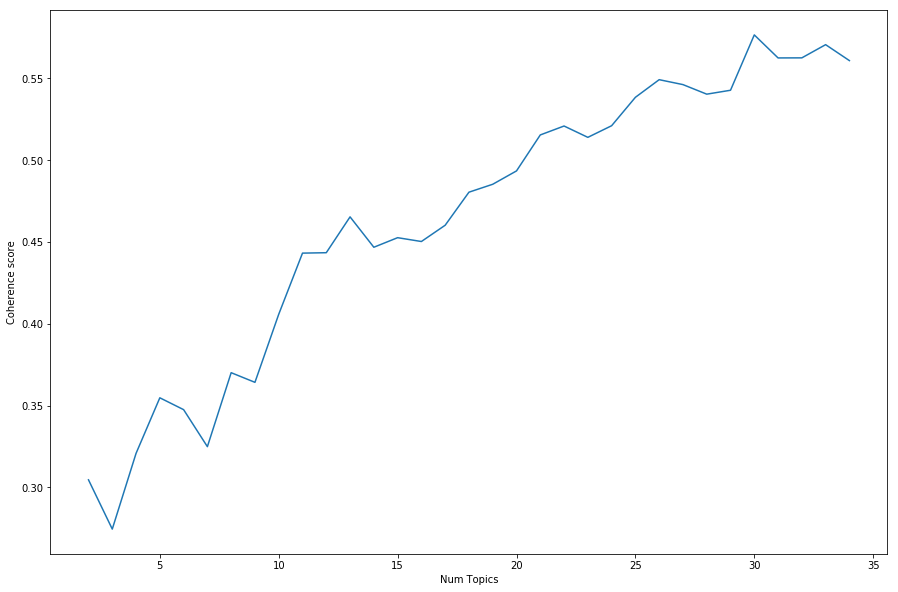

In [54]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [55]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.304606
Num Topics = 3  has Coherence Value of 0.274503
Num Topics = 4  has Coherence Value of 0.320775
Num Topics = 5  has Coherence Value of 0.354731
Num Topics = 6  has Coherence Value of 0.347488
Num Topics = 7  has Coherence Value of 0.324879
Num Topics = 8  has Coherence Value of 0.370077
Num Topics = 9  has Coherence Value of 0.36418
Num Topics = 10  has Coherence Value of 0.405765
Num Topics = 11  has Coherence Value of 0.443135
Num Topics = 12  has Coherence Value of 0.443393
Num Topics = 13  has Coherence Value of 0.465292
Num Topics = 14  has Coherence Value of 0.446727
Num Topics = 15  has Coherence Value of 0.452572
Num Topics = 16  has Coherence Value of 0.450234
Num Topics = 17  has Coherence Value of 0.460179
Num Topics = 18  has Coherence Value of 0.480374
Num Topics = 19  has Coherence Value of 0.485214
Num Topics = 20  has Coherence Value of 0.493375
Num Topics = 21  has Coherence Value of 0.515358
Num Topics = 22  has Coherenc

In [56]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 10
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.100*"jame" + 0.054*"train" + 0.054*"lily" + 0.038*"mother" + 0.038*"give" '
  '+ 0.031*"trolley" + 0.023*"catch" + 0.023*"matter" + 0.023*"barrier" + '
  '0.023*"hugo"'),
 (1,
  '0.103*"ron" + 0.089*"face" + 0.048*"hermione" + 0.041*"watch" + '
  '0.034*"slytherin" + 0.034*"people" + 0.027*"steam" + 0.021*"love" + '
  '0.021*"point" + 0.021*"suddenly"'),
 (2,
  '0.069*"thing" + 0.060*"door" + 0.060*"laugh" + 0.043*"write" + '
  '0.034*"inside" + 0.034*"find" + 0.034*"meet" + 0.026*"boy" + 0.026*"put" + '
  '0.026*"hang"'),
 (3,
  '0.056*"year" + 0.040*"week" + 0.032*"push" + 0.032*"rattle" + 0.032*"day" + '
  '0.024*"slightly" + 0.024*"wave" + 0.024*"-PRON-" + 0.024*"hug" + '
  '0.024*"large"'),
 (4,
  '0.092*"hogwart" + 0.065*"hear" + 0.060*"elf" + 0.043*"shake" + 0.038*"time" '
  '+ 0.038*"sound" + 0.033*"aunt_petunia" + 0.033*"voice" + 0.027*"speak" + '
  '0.022*"mr"'),
 (5,
  '0.085*"make" + 0.068*"stop" + 0.060*"letter" + 0.026*"stomach" + '
  '0.026*"corner" + 0.026*"ru

In [57]:
optimal_model.show_topic(0,10)

[('jame', 0.1),
 ('train', 0.05384615384615385),
 ('lily', 0.05384615384615385),
 ('mother', 0.038461538461538464),
 ('give', 0.038461538461538464),
 ('trolley', 0.03076923076923077),
 ('catch', 0.023076923076923078),
 ('matter', 0.023076923076923078),
 ('barrier', 0.023076923076923078),
 ('hugo', 0.023076923076923078)]

In [58]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['jame', 'train', 'lily', 'mother', 'give', 'trolley', 'catch', 'matter', 'barrier', 'hugo']
Topic 1: ['ron', 'face', 'hermione', 'watch', 'slytherin', 'people', 'steam', 'love', 'point', 'suddenly']
Topic 2: ['thing', 'door', 'laugh', 'write', 'inside', 'find', 'meet', 'boy', 'put', 'hang']
Topic 3: ['year', 'week', 'push', 'rattle', 'day', 'slightly', 'wave', '-PRON-', 'hug', 'large']
Topic 4: ['hogwart', 'hear', 'elf', 'shake', 'time', 'sound', 'aunt_petunia', 'voice', 'speak', 'mr']
Topic 5: ['make', 'stop', 'letter', 'stomach', 'corner', 'run', 'vanish', 'dudley', 'quickly', 'size']
Topic 6: ['albus', 'ginny', 'brother', 'al', 'teddy', 'rise', 'family', 'son', 'platform', 'owl']
Topic 7: ['dobby', 'potter', 'head', 'mason', 'start', 'magic', 'kitchen', 'bad', 'creature', 'downstairs']
Topic 8: ['bed', 'dursley', 'bar', 'friend', 'family', 'flap', 'wall', 'bowl', 'plot', 'shut']
Topic 9: ['harry', 'uncle_vernon', 'great', 'good', 'sit', 'long', 'turn', 'close', 'shout', 't

In [59]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.1790,"dobby, potter, head, mason, start, magic, kitc...",Chapter 2 DOBBY'S WARNINGHarry managed not to ...
1,1,6.0,0.2465,"albus, ginny, brother, al, teddy, rise, family...",Epilogue NINETEEN YEARS LATERAutumn seemed to ...


In [60]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([0, 1])]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text


In [0]:
[text.split() for text in df_dominant_topic['Keywords'].tolist()]

[['hagrid,',
  'harry,',
  'uncle_vernon,',
  'yeh,',
  'dudley,',
  'ter,',
  'back,',
  'dursley,',
  '-PRON-,',
  'aunt_petunia'],
 ['hagrid,',
  'harry,',
  'uncle_vernon,',
  'yeh,',
  'dudley,',
  'ter,',
  'back,',
  'dursley,',
  '-PRON-,',
  'aunt_petunia'],
 ['hagrid,',
  'harry,',
  'uncle_vernon,',
  'yeh,',
  'dudley,',
  'ter,',
  'back,',
  'dursley,',
  '-PRON-,',
  'aunt_petunia'],
 ['hagrid,',
  'harry,',
  'uncle_vernon,',
  'yeh,',
  'dudley,',
  'ter,',
  'back,',
  'dursley,',
  '-PRON-,',
  'aunt_petunia'],
 ['harry,',
  'mr_weasley,',
  'door,',
  'wizard,',
  'hogwart,',
  'percy,',
  'fr,',
  'muggle,',
  'large,',
  'witch'],
 ['harry,',
  'mr_weasley,',
  'door,',
  'wizard,',
  'hogwart,',
  'percy,',
  'fr,',
  'muggle,',
  'large,',
  'witch'],
 ['harry,',
  'malfoy,',
  'ron,',
  'gryffindor,',
  'slytherin,',
  'professor_mcgonagall,',
  'filch,',
  'weasley,',
  'face,',
  'team'],
 ['umbridge,',
  'professor,',
  'class,',
  'harry,',
  'year,',
  'le

In [61]:
for idx, row in df_dominant_topic.iterrows():
    print('{}. Dominant keywords: {}'.format(row['Document_No'], row['Keywords'].split(', ')[:5]))

0. Dominant keywords: ['dobby', 'potter', 'head', 'mason', 'start']
1. Dominant keywords: ['albus', 'ginny', 'brother', 'al', 'teddy']


In [62]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,6.0,0.2465,"albus, ginny, brother, al, teddy, rise, family...",Epilogue NINETEEN YEARS LATERAutumn seemed to ...
1,7.0,0.1790,"dobby, potter, head, mason, start, magic, kitc...",Chapter 2 DOBBY'S WARNINGHarry managed not to ...


In [63]:
for idx, row in sent_topics_sorteddf_mallet.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 6
Keywords: albus, ginny, brother, al, teddy, rise, family, son, platform, owl

Epilogue NINETEEN YEARS LATERAutumn seemed to arrive suddenly that year. The morning of the first of September was crisp and golden as an apple, and as the little family bobbed across the rumbling road toward the great sooty station, the fumes of car exhausts and the breath of pedestrians sparkled like cobwebs in the cold air. Two large cages rattled on top of the laden trolleys the parents were pushing; the owls inside them hooted indignantly, and the redheaded girl trailed tearfully behind her brothers, clutching her father's arm. "It won't be long, and you'll be going too," Harry told her. "Two years," sniffed Lily. "I want to go now!" The commuters stared curiously at the owls as the family wove its way toward the barrier between platforms nine and ten. Albus's voice drifted back to Harry over the surrounding clamor; his sons had resumed the argument they had started in the car. "I won't! I

In [64]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,6.0,"albus, ginny, brother, al, teddy, rise, family...",NaN,NaN
1.0,7.0,"dobby, potter, head, mason, start, magic, kitc...",NaN,NaN
6.0,NaN,NaN,1.0,0.5
7.0,NaN,NaN,1.0,0.5


In [65]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,6.0,"albus, ginny, brother, al, teddy, rise, family, son, platform, owl",NaN,NaN
1.0,7.0,"dobby, potter, head, mason, start, magic, kitchen, bad, creature, downstairs",NaN,NaN
6.0,NaN,NaN,1.0,0.5
7.0,NaN,NaN,1.0,0.5


In [0]:
df_dominant_topics.to_csv('df_dominant_topics.csv', index=False)

# LDA using individual sentences as documents

In [71]:
import nltk
nltk.download('punkt')

from nltk import tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
# Convert to list
data = []
for book in hp:
    for chapter in hp[book]:
        data.extend(tokenize.sent_tokenize(hp[book][chapter][1].replace('\n', '')))

In [73]:
# Convert to list
print('Creating corpus')
data = []
for book in hp:
    for chapter in hp[book]:
        data.extend(tokenize.sent_tokenize(hp[book][chapter][1].replace('\n', '')))

# Tokenize into words
print('Tokenizing')
data_words = list(sent_to_words(data))

# Build the bigram and trigram models
print('Creating bigrams and trigrams')
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
print('Building bigram and trigram models')
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
print('Removing stopwords')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
print('Forming bigrams')
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
print('Lemmatizing')
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Create Dictionary
print('Creating dictionary')
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
print('Creating corpus')
texts = data_lemmatized

# Term Document Frequency
print('Creating term frequency list')
corpus = [id2word.doc2bow(text) for text in texts]

Creating corpus
Tokenizing
Creating bigrams and trigrams
Building bigram and trigram models
Removing stopwords
Forming bigrams


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Lemmatizing
Creating dictionary
Creating corpus
Creating term frequency list


In [74]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [75]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


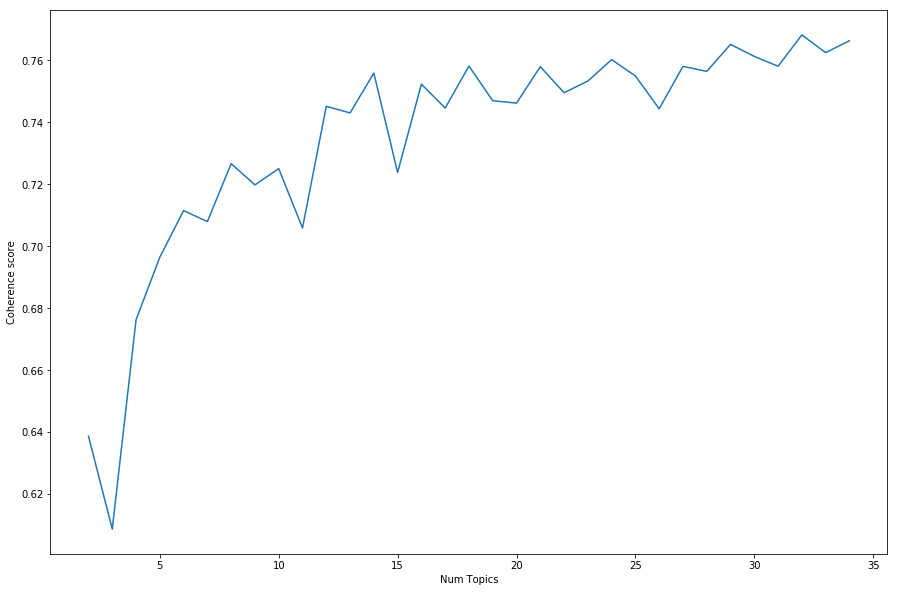

In [76]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [77]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.638621
Num Topics = 3  has Coherence Value of 0.608624
Num Topics = 4  has Coherence Value of 0.676246
Num Topics = 5  has Coherence Value of 0.696437
Num Topics = 6  has Coherence Value of 0.711488
Num Topics = 7  has Coherence Value of 0.707949
Num Topics = 8  has Coherence Value of 0.726664
Num Topics = 9  has Coherence Value of 0.719791
Num Topics = 10  has Coherence Value of 0.725055
Num Topics = 11  has Coherence Value of 0.705888
Num Topics = 12  has Coherence Value of 0.745193
Num Topics = 13  has Coherence Value of 0.743032
Num Topics = 14  has Coherence Value of 0.75592
Num Topics = 15  has Coherence Value of 0.723816
Num Topics = 16  has Coherence Value of 0.752324
Num Topics = 17  has Coherence Value of 0.744629
Num Topics = 18  has Coherence Value of 0.758175
Num Topics = 19  has Coherence Value of 0.746981
Num Topics = 20  has Coherence Value of 0.746216
Num Topics = 21  has Coherence Value of 0.757977
Num Topics = 22  has Coherenc

In [0]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 6
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)

In [79]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

Perplexity:  -7.346931413349731
Coherence Score:  0.5459666119966957


/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [0]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['harry', 'hagrid', 'malfoy', 'mr', 'weasley', 'watch', 'ginny', 'neville', 'yeah', 'gryffindor']
Topic 1: ['dumbledore', 'voldemort', '-PRON-', 'potter', 'wizard', 'people', 'boy', 'kill', 'dobby', 'return']
Topic 2: ['harry', 'ron', 'hermione', 'head', 'turn', 'back', 'star', 'voice', 'shake', 'mouth']
Topic 3: ['harry', 'face', 'hand', 'snape', 'wand', 'feel', 'eye', 'point', 'pull', 'voice']
Topic 4: ['harry', 'make', 'time', 'give', 'sirius', 'lupin', 'stop', 'place', 'speak', 'man']
Topic 5: ['back', 'door', 'hear', 'open', 'room', 'sit', 'moment', 'leave', 'stand', 'front']
Topic 6: ['good', 'find', 'professor', 'thing', 'year', 'fr', 'happen', 'hogwart', 'george', 'talk']
Topic 7: ['black', 'foot', 'eye', 'long', 'dark', 'large', 'light', 'fall', 'floor', 'window']


In [80]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [82]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,6.0,"albus, ginny, brother, al, teddy, rise, family, son, platform, owl",201,0.3800
1.0,7.0,"dobby, potter, head, mason, start, magic, kitchen, bad, creature, downstairs",47,0.0888
2.0,NaN,NaN,53,0.1002
3.0,NaN,NaN,40,0.0756
4.0,NaN,NaN,34,0.0643
5.0,NaN,NaN,50,0.0945
6.0,NaN,NaN,43,0.0813
7.0,NaN,NaN,61,0.1153
